In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# preparing cifar10 dataset
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 45159201.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

In [ ]:
train_loader.dataset[0][0].size()

torch.Size([3, 32, 32])

Text(0.5, 0.98, 'CIFAR10 dataset')

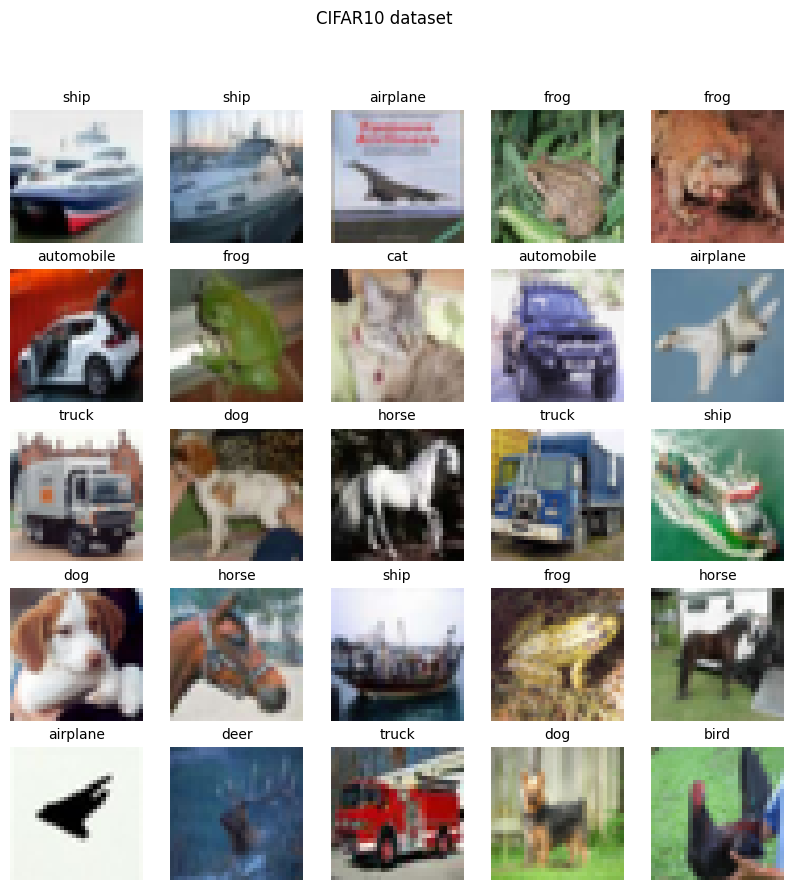

In [ ]:
fig = plt.figure(figsize=(10, 10))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(test_data.data[index])
  title = f'{test_data.classes[test_data[index][1]]}'
  plt.title(title, fontsize=10)
plt.suptitle('CIFAR10 dataset')

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.pool2 = nn.MaxPool2d(2)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool3 = nn.MaxPool2d(2)
    self.dr1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.dr2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(1024, 512)
    self.dr3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x)
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool3(x)
    x = x.view(-1, np.prod(x.size()[1:]))
    x = self.dr1(x)
    x = F.relu(self.fc1(x))
    x = self.dr2(x)
    x = F.relu(self.fc2(x))
    x = self.dr3(x)
    logits = self.fc3(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [ ]:
model = ConvNet().to(device)
optimizer = optim.Adadelta(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 60
random_seed = 42

In [ ]:
def train(model, train_loader, optimizer, loss_fn, device):
  '''
  training step
  '''

  model.train()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, y_hat_probs = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat_probs, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_accuracy = num_correct_pred / len(train_loader.dataset)
  return model, optimizer, epoch_loss, epoch_accuracy

In [ ]:
def test(model, test_loader, loss_fn, device):
  '''
  test iteration
  '''

  model.eval()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, y_hat_probs = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat_probs, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)
  
  epoch_loss = running_loss / len(test_loader.dataset)
  epoch_accuracy = num_correct_pred / len(test_loader.dataset)
  return model, epoch_loss, epoch_accuracy

In [ ]:
def training_loop(model, train_loader, test_loader, loss_fn, optimizer, n_epochs, device):

  train_losses = []
  test_losses = []

  for epoch in tqdm(range(n_epochs), desc='Epoch'):
    model, optimizer, train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, test_loss, test_accuracy = test(model, test_loader, loss_fn, device)
      test_losses.append(test_loss)

    print(f'train loss:{train_loss:.4f} test_loss:{test_loss:.4f} train_accuracy:{train_accuracy * 100:.2f}% test_accuracy:{test_accuracy * 100:.2f}%')

  return model, optimizer, train_losses, test_losses

In [ ]:
model, optimizer, train_losses, test_losses = training_loop(model, train_loader, test_loader, loss_fn, optimizer, n_epochs, device)

Epoch:   2%|▏         | 1/60 [00:18<18:14, 18.55s/it]

train loss:2.3028 test_loss:2.2967 train_accuracy:10.04% test_accuracy:12.86%


Epoch:   3%|▎         | 2/60 [00:29<13:33, 14.03s/it]

train loss:2.2638 test_loss:2.0551 train_accuracy:13.45% test_accuracy:23.84%


Epoch:   5%|▌         | 3/60 [00:40<11:59, 12.62s/it]

train loss:2.0461 test_loss:2.0405 train_accuracy:24.59% test_accuracy:25.26%


Epoch:   7%|▋         | 4/60 [00:51<11:07, 11.92s/it]

train loss:1.8213 test_loss:1.7642 train_accuracy:32.91% test_accuracy:35.66%


Epoch:   8%|▊         | 5/60 [01:01<10:25, 11.38s/it]

train loss:1.6432 test_loss:1.5217 train_accuracy:39.72% test_accuracy:43.17%


Epoch:  10%|█         | 6/60 [01:12<10:05, 11.21s/it]

train loss:1.5004 test_loss:1.3701 train_accuracy:45.46% test_accuracy:49.89%


Epoch:  12%|█▏        | 7/60 [01:24<10:05, 11.43s/it]

train loss:1.3700 test_loss:1.2524 train_accuracy:50.42% test_accuracy:55.00%


Epoch:  13%|█▎        | 8/60 [01:35<09:46, 11.27s/it]

train loss:1.2390 test_loss:1.2621 train_accuracy:55.75% test_accuracy:55.25%


Epoch:  15%|█▌        | 9/60 [01:46<09:28, 11.15s/it]

train loss:1.1236 test_loss:0.9841 train_accuracy:59.93% test_accuracy:65.63%


Epoch:  17%|█▋        | 10/60 [01:57<09:14, 11.09s/it]

train loss:1.0156 test_loss:0.9568 train_accuracy:64.51% test_accuracy:66.57%


Epoch:  18%|█▊        | 11/60 [02:08<09:00, 11.04s/it]

train loss:0.9311 test_loss:0.9147 train_accuracy:67.73% test_accuracy:67.94%


Epoch:  20%|██        | 12/60 [02:18<08:47, 11.00s/it]

train loss:0.8615 test_loss:0.8661 train_accuracy:70.20% test_accuracy:69.25%


Epoch:  22%|██▏       | 13/60 [02:29<08:36, 10.99s/it]

train loss:0.7991 test_loss:0.8463 train_accuracy:72.44% test_accuracy:70.81%


Epoch:  23%|██▎       | 14/60 [02:40<08:24, 10.97s/it]

train loss:0.7409 test_loss:0.9901 train_accuracy:74.50% test_accuracy:66.43%


Epoch:  25%|██▌       | 15/60 [02:51<08:11, 10.93s/it]

train loss:0.7014 test_loss:0.8079 train_accuracy:75.97% test_accuracy:73.05%


Epoch:  27%|██▋       | 16/60 [03:02<07:56, 10.83s/it]

train loss:0.6603 test_loss:0.7549 train_accuracy:77.54% test_accuracy:74.23%


Epoch:  28%|██▊       | 17/60 [03:13<07:45, 10.84s/it]

train loss:0.6193 test_loss:0.7900 train_accuracy:78.83% test_accuracy:73.78%


Epoch:  30%|███       | 18/60 [03:24<07:37, 10.90s/it]

train loss:0.5883 test_loss:0.7295 train_accuracy:79.65% test_accuracy:75.36%


Epoch:  32%|███▏      | 19/60 [03:35<07:26, 10.90s/it]

train loss:0.5586 test_loss:0.7233 train_accuracy:80.86% test_accuracy:75.46%


Epoch:  33%|███▎      | 20/60 [03:46<07:16, 10.92s/it]

train loss:0.5294 test_loss:0.7697 train_accuracy:81.83% test_accuracy:74.96%


Epoch:  35%|███▌      | 21/60 [03:57<07:06, 10.93s/it]

train loss:0.5119 test_loss:0.7802 train_accuracy:82.45% test_accuracy:76.30%


Epoch:  37%|███▋      | 22/60 [04:08<06:56, 10.97s/it]

train loss:0.4899 test_loss:0.6617 train_accuracy:83.24% test_accuracy:78.02%


Epoch:  38%|███▊      | 23/60 [04:19<06:48, 11.03s/it]

train loss:0.4662 test_loss:0.6813 train_accuracy:83.89% test_accuracy:77.68%


Epoch:  40%|████      | 24/60 [04:30<06:36, 11.01s/it]

train loss:0.4496 test_loss:0.6547 train_accuracy:84.85% test_accuracy:78.88%


Epoch:  42%|████▏     | 25/60 [04:41<06:24, 10.99s/it]

train loss:0.4334 test_loss:0.6422 train_accuracy:85.25% test_accuracy:78.97%


Epoch:  43%|████▎     | 26/60 [04:51<06:09, 10.87s/it]

train loss:0.4126 test_loss:0.7256 train_accuracy:86.07% test_accuracy:77.24%


Epoch:  45%|████▌     | 27/60 [05:02<05:57, 10.84s/it]

train loss:0.4070 test_loss:0.6617 train_accuracy:86.13% test_accuracy:79.34%


Epoch:  47%|████▋     | 28/60 [05:13<05:48, 10.90s/it]

train loss:0.3904 test_loss:0.6444 train_accuracy:86.89% test_accuracy:79.82%


Epoch:  48%|████▊     | 29/60 [05:24<05:38, 10.92s/it]

train loss:0.3794 test_loss:0.6856 train_accuracy:87.30% test_accuracy:78.03%


Epoch:  50%|█████     | 30/60 [05:35<05:29, 10.99s/it]

train loss:0.3639 test_loss:0.6689 train_accuracy:87.69% test_accuracy:79.05%


Epoch:  52%|█████▏    | 31/60 [05:46<05:19, 11.01s/it]

train loss:0.3587 test_loss:0.7986 train_accuracy:88.03% test_accuracy:76.53%


Epoch:  53%|█████▎    | 32/60 [05:57<05:07, 10.99s/it]

train loss:0.3515 test_loss:0.6902 train_accuracy:87.99% test_accuracy:79.21%


Epoch:  55%|█████▌    | 33/60 [06:08<04:57, 11.00s/it]

train loss:0.3453 test_loss:0.6621 train_accuracy:88.44% test_accuracy:79.67%


Epoch:  57%|█████▋    | 34/60 [06:19<04:46, 11.02s/it]

train loss:0.3327 test_loss:0.7145 train_accuracy:88.69% test_accuracy:79.44%


Epoch:  58%|█████▊    | 35/60 [06:30<04:35, 11.02s/it]

train loss:0.3258 test_loss:0.6563 train_accuracy:89.02% test_accuracy:80.12%


Epoch:  60%|██████    | 36/60 [06:41<04:22, 10.96s/it]

train loss:0.3167 test_loss:0.6949 train_accuracy:89.35% test_accuracy:79.87%


Epoch:  62%|██████▏   | 37/60 [06:52<04:09, 10.83s/it]

train loss:0.3196 test_loss:0.7006 train_accuracy:89.29% test_accuracy:79.35%


Epoch:  63%|██████▎   | 38/60 [07:03<03:59, 10.90s/it]

train loss:0.3052 test_loss:0.6645 train_accuracy:89.78% test_accuracy:79.97%


Epoch:  65%|██████▌   | 39/60 [07:14<03:49, 10.93s/it]

train loss:0.2995 test_loss:0.6736 train_accuracy:90.02% test_accuracy:81.41%


Epoch:  67%|██████▋   | 40/60 [07:25<03:38, 10.93s/it]

train loss:0.3022 test_loss:0.6316 train_accuracy:89.93% test_accuracy:81.15%


Epoch:  68%|██████▊   | 41/60 [07:36<03:28, 10.99s/it]

train loss:0.2874 test_loss:0.6732 train_accuracy:90.47% test_accuracy:80.71%


Epoch:  70%|███████   | 42/60 [07:47<03:17, 10.95s/it]

train loss:0.2886 test_loss:0.7018 train_accuracy:90.54% test_accuracy:79.13%


Epoch:  72%|███████▏  | 43/60 [07:58<03:05, 10.94s/it]

train loss:0.2795 test_loss:0.6646 train_accuracy:90.87% test_accuracy:79.62%


Epoch:  73%|███████▎  | 44/60 [08:09<02:55, 10.97s/it]

train loss:0.2739 test_loss:0.6676 train_accuracy:90.95% test_accuracy:80.67%


Epoch:  75%|███████▌  | 45/60 [08:20<02:44, 10.99s/it]

train loss:0.2750 test_loss:0.6849 train_accuracy:90.97% test_accuracy:80.81%


Epoch:  77%|███████▋  | 46/60 [08:30<02:33, 10.94s/it]

train loss:0.2706 test_loss:0.7130 train_accuracy:91.37% test_accuracy:79.99%


Epoch:  78%|███████▊  | 47/60 [08:41<02:20, 10.83s/it]

train loss:0.2688 test_loss:0.6623 train_accuracy:91.15% test_accuracy:81.41%


Epoch:  80%|████████  | 48/60 [08:52<02:09, 10.78s/it]

train loss:0.2628 test_loss:0.8368 train_accuracy:91.41% test_accuracy:78.34%


Epoch:  82%|████████▏ | 49/60 [09:03<01:59, 10.83s/it]

train loss:0.2568 test_loss:0.6819 train_accuracy:91.63% test_accuracy:81.34%


Epoch:  83%|████████▎ | 50/60 [09:14<01:48, 10.89s/it]

train loss:0.2584 test_loss:0.6533 train_accuracy:91.64% test_accuracy:80.92%


Epoch:  85%|████████▌ | 51/60 [09:25<01:38, 10.93s/it]

train loss:0.2545 test_loss:0.6591 train_accuracy:91.78% test_accuracy:80.81%


Epoch:  87%|████████▋ | 52/60 [09:36<01:27, 10.99s/it]

train loss:0.2509 test_loss:0.6486 train_accuracy:91.93% test_accuracy:81.21%


Epoch:  88%|████████▊ | 53/60 [09:47<01:16, 10.97s/it]

train loss:0.2507 test_loss:0.6888 train_accuracy:91.99% test_accuracy:79.74%


Epoch:  90%|█████████ | 54/60 [09:58<01:05, 10.92s/it]

train loss:0.2509 test_loss:0.7451 train_accuracy:92.04% test_accuracy:78.54%


Epoch:  92%|█████████▏| 55/60 [10:09<00:54, 10.97s/it]

train loss:0.2536 test_loss:0.6809 train_accuracy:91.97% test_accuracy:81.40%


Epoch:  93%|█████████▎| 56/60 [10:20<00:43, 10.94s/it]

train loss:0.2469 test_loss:0.6360 train_accuracy:92.07% test_accuracy:81.39%


Epoch:  95%|█████████▌| 57/60 [10:30<00:32, 10.84s/it]

train loss:0.2415 test_loss:0.7798 train_accuracy:92.45% test_accuracy:78.65%


Epoch:  97%|█████████▋| 58/60 [10:41<00:21, 10.77s/it]

train loss:0.2359 test_loss:0.8510 train_accuracy:92.55% test_accuracy:77.86%


Epoch:  98%|█████████▊| 59/60 [10:52<00:10, 10.81s/it]

train loss:0.2320 test_loss:0.7333 train_accuracy:92.59% test_accuracy:79.79%


Epoch: 100%|██████████| 60/60 [11:03<00:00, 11.06s/it]

train loss:0.2276 test_loss:0.6831 train_accuracy:92.75% test_accuracy:80.32%


In [ ]:
torch.save(model.state_dict(), 'ConvNetCIFAR.pt')

Text(0.5, 0.98, 'CIFAR10 dataset')

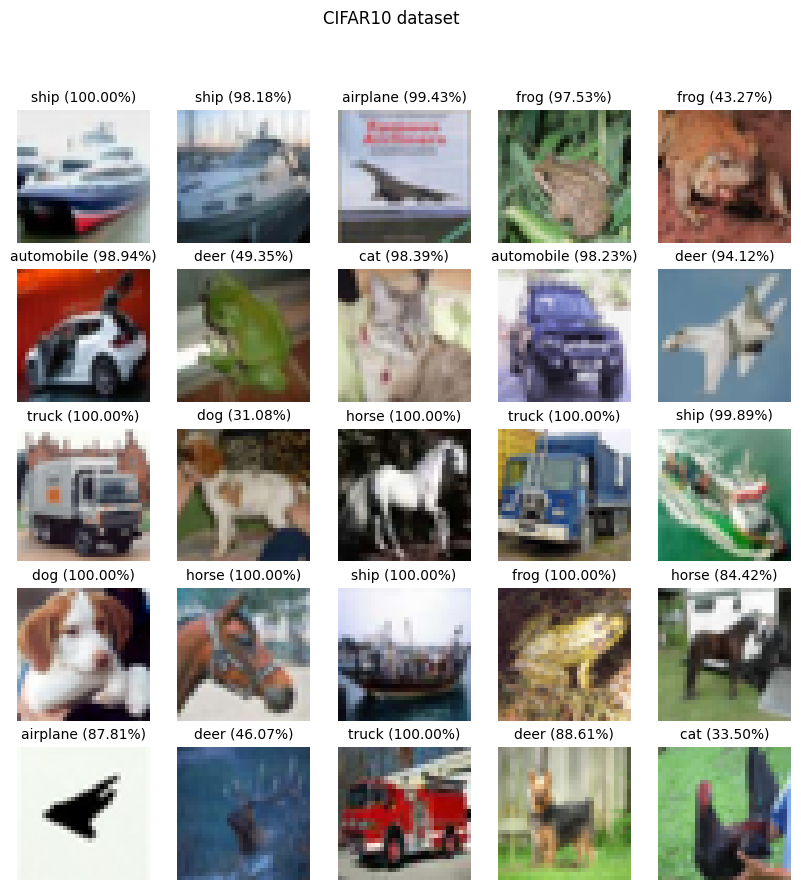

In [ ]:
fig = plt.figure(figsize=(10, 10))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(test_data.data[index])

  with torch.no_grad():
    model.eval()
    __, probs = model(test_data[index][0].unsqueeze(0).to(device))
  title = f'{test_data.classes[torch.argmax(probs, 1)]} ({torch.max(probs) * 100:.2f}%)'
  plt.title(title, fontsize=10)
plt.suptitle('CIFAR10 dataset')